# Data Cleaning and Creating CSV files for SQL

Here, I will clean the Glassdoor job posting data set which I scraped and create csv files for creating a relational database.

In [164]:
import pandas as pd
import numpy as np

## Reading the Data

In [165]:
df = pd.read_csv(r'...\glassdoor_data_analyst.csv')

In [166]:
df.head()

,company,title,location,salary,rating,size,industry,sector,revenue,job_description
0,CTG,DATA CENTER SERVICES ANALYST I,"Anchorage, AK",NaN,3.4,1001 to 5000 Employees,IT Services,Information Technology,$100 to $500 million (USD),CTG is searching for a full time *Data Center ...
1,Manmade Creative Inc,DATA ANALYST and HEALTH,"Anchorage, AK",NaN,NaN,NaN,NaN,NaN,NaN,"Familiarity in analysis reporting, data entry,..."
2,DS Technologies Inc,Data Analyst,Alaska,NaN,5.0,1 to 50 Employees,NaN,NaN,$1 to $5 million (USD),"Hi,Greetings from DSTechnologiesinc!\n\nIam re..."
3,Integrated Statistics,Data Analyst/Modeler,"Anchorage, AK",$48K-$86K,5.0,51 to 200 Employees,"Health, Beauty, & Fitness",Consumer Services,$5 to $10 million (USD),Data Analyst/Modeler Needed\n\nIntegrated Stat...
4,Southcentral Foundation,Data Analyst,"Anchorage, AK",$39K-$68K,3.5,1001 to 5000 Employees,Membership Organizations,Business Services,$100 to $500 million (USD),The Southcentral Foundation (SCF) Data Analyst...


In [167]:
df.shape

(3188, 10)

## Duplicates

The same job postings can be posibly posted multiple times. Let's remove duplciates.

In [168]:
df = df.drop_duplicates().reset_index(drop=True)
df.shape

(2378, 10)

The total number of the distinct job postings in the data set is 2378.

## Missing Values

In [169]:
import missingno as msno

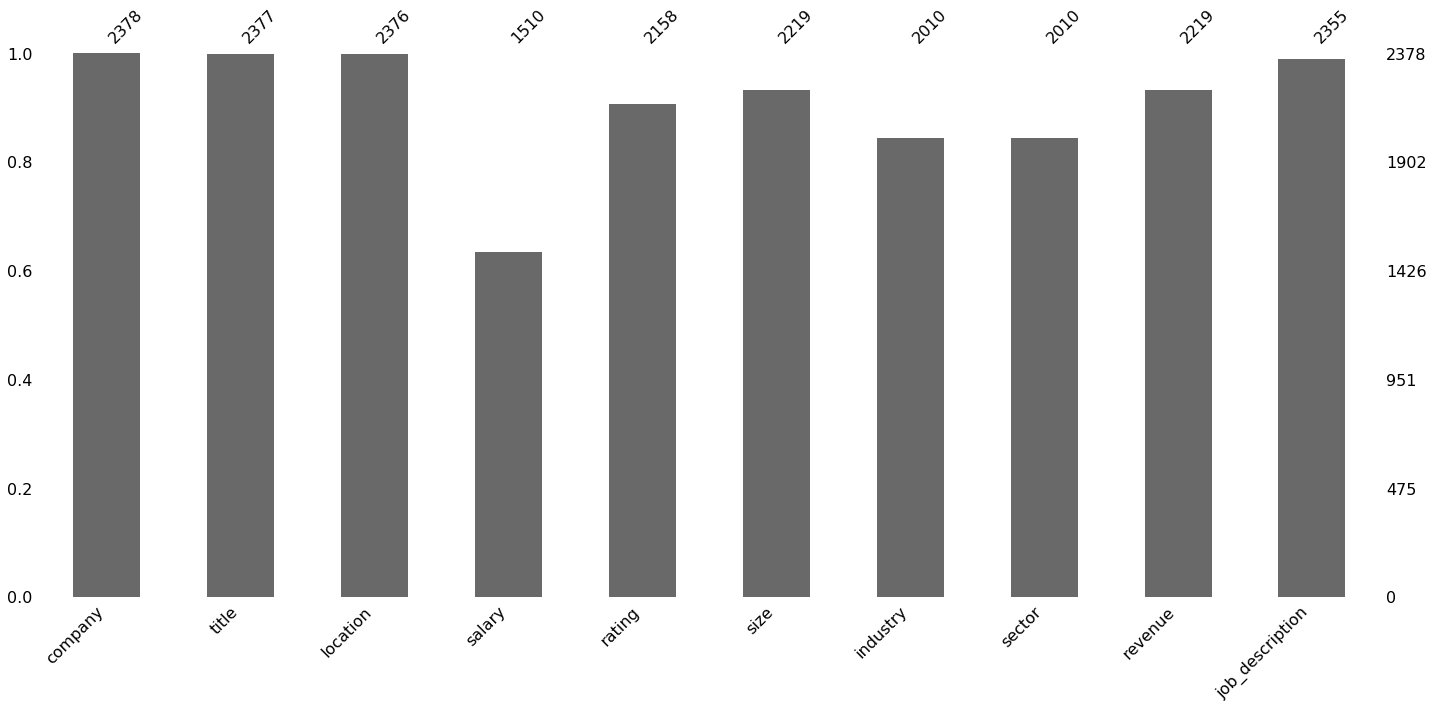

In [170]:
msno.bar(df)

## Job Location

Basically, **location** has the imformation about city and state for each job posting. Therefore, I will create columns for **state** and **city** using the info in the column **location**.

As seen in the bar chart for missing values, there are two rows which have missing values in **location**.

In [171]:
df[df.location.isnull()]

,company,title,location,salary,rating,size,industry,sector,revenue,job_description
1046,softsnippets,Data Analyst - Reverse Engineer,NaN,$36K-$67K,4.6,51 to 200 Employees,Consulting,Business Services,$5 to $10 million (USD),Data Analyst/ Clinical Data Analyst\n8 month +...
1946,LMI,Data Analyst - Clearance Required,NaN,NaN,3.7,1001 to 5000 Employees,Social Assistance,Non-Profit,$100 to $500 million (USD),"Data Analyst*\nAction for Children (AFC), cent..."


Google says that **softsnippets** is located in the **'Jacksonville, FL'**, and the headquarter of the **LMI** is located in the **'Tysons, VA'**. Therefore, I will enter these info into **location** for those companies.

In [172]:
df.loc[1046,'location'] = 'Jacksonville, FL'
df.loc[1946,'location'] = 'Tysons, VA'

For the **location**, some rows have *comma*(**,**) in it and others have not. The rows having (**,**) in **location** basicially have the format of **city, state** and the rows without **','** have simply state full names in **location**. In creating **state** and **city**, we should use different ways for each case.

In [173]:
df.location.str.contains(',').value_counts()

True     2292
False      86
Name: location, dtype: int64

Out of 2378 rows, 2292 rows have *comma* in **location** while 86 rows have not. Let's start with the rows without *comma* in **location**.

In [174]:
df[df.location.str.contains(',')==False].location.unique()

array(['Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Georgia', 'Hawaii',
       'Illinois', 'Indiana', 'Kansas', 'Massachusetts', 'Maryland',
       'Michigan', 'Minnesota', 'North Carolina', 'New Hampshire',
       'New Jersey', 'Nevada', 'Ohio', 'Oklahoma', 'Oregon',
       'United States', 'Rhode Island', 'South Carolina', 'Tennessee',
       'Bristol', 'Texas'], dtype=object)

The array above shows the unique values in **location** for the rows without *comma* in **location**. Among the list of the names, '**Bristol**' is not clearly identified because it is the city name which multiple states have. And **'United States'** can be considered Null. Let's see the names of companies for the records.

In [175]:
df[df.location=='Bristol']

,company,title,location,salary,rating,size,industry,sector,revenue,job_description
2236,King University,Data Analyst,Bristol,NaN,4.4,1001 to 5000 Employees,Colleges & Universities,Education,Less than $1 million (USD),"Description: Bristol, TN The position of the D..."


The name of company is **'King University'**, which is located in Bristol, Tennessee. Therefore, I will enter 'Bristol, TN' instead of 'Bristol' for the **location**.

In [176]:
df.loc[2236,'location'] = 'Bristol,TN'

In [177]:
df[df.location=='United States']

,company,title,location,salary,rating,size,industry,sector,revenue,job_description
2120,Efinancial,Marketing Data Analyst,United States,NaN,3.6,201 to 500 Employees,Insurance Agencies & Brokerages,Insurance,$50 to $100 million (USD),Overview\n\n\nAs a key member of the Analytics...


*Google* says that **'Efinancial'** is located in **'Bellevue, WA'**.

In [178]:
df.loc[2120,'location'] = 'Bellevue, WA'

### Creating the column for state

Create the column for **state** first, and then enter **'Unknown'** as the initial value. 

In [179]:
df['state'] = 'Unknown'

In [180]:
# create a dictionary for the US state full names and their abbreviations
state_names = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

The records which do not have *comma* in **location** have the state full names in **location**. Since I want to enter the abbreviation in **state**, I will convert the full names into the abbreviations.

In [181]:
for i in df[df.location.str.contains(',')==False].index:
    for key, value in state_names.items():
        if df.loc[i,'location'] == value:
            df.loc[i,'state'] = key 

For the records with *comma* in **location**, I will pick the abbreviations of the state names and enter them into **state** column.

In [182]:
for i in df[df.location.str.contains(',')==True].index:
    if len(df.loc[i,'location'].split(',')) > 2:
        df.loc[i,'state'] = df.loc[i,'location'].split(',')[2].strip() # the case for the format (region1, region2, state)
    if len(df.loc[i,'location'].split(',')) == 2:
        df.loc[i,'state'] = df.loc[i,'location'].split(',')[1].strip() # the case for the format (region(city), state)

### Creating the column for city

In [183]:
df['city'] = 'Unknown'

for i in df[df.location.str.contains(',')==True].index:
    df.loc[i,'city'] = df.loc[i,'location'].split(',')[0].strip()

## Salary

Let's see the unique values in **salary**.

In [184]:
df.salary.unique()

array([nan, '$48K-$86K', '$39K-$68K', '$67K-$148K', '$26K-$48K',
       '$43K-$101K', '$36K-$69K', '$55K-$94K', '$38K-$70K', '$59K-$80K',
       '$43K-$79K', '$40K-$65K', '$33K-$60K', '$30K-$54K', '$38K-$71K',
       '$30K-$61K', '$27K-$56K', '$29K-$59K', '$47K-$84K', '$34K-$59K',
       '$32K-$64K', '$49K-$80K', '$29K-$60K', '$35K-$61K', '$44K-$80K',
       '$41K-$77K', '$36K-$68K', '$26K-$71K', '$38K-$68K', '$35K-$66K',
       '$41K-$70K', '$34K-$65K', '$46K-$159K', '$38K-$90K', '$39K-$71K',
       '$56K-$94K', '$35K-$64K', '$71K-$118K', '$49K-$84K', '$31K-$54K',
       '$34K-$61K', '$70K-$121K', '$29K-$51K', '$42K-$75K', '$65K-$114K',
       '$57K-$96K', '$85K-$142K', '$32K-$58K', '$33K-$59K', '$80K-$136K',
       '$61K-$110K', '$45K-$52K', '$27K-$51K', '$53K-$96K', '$36K-$65K',
       '$38K-$74K', '$49K-$86K', '$45K-$81K', '$34K-$60K', '$48K-$89K',
       '$48K-$85K', '$40K-$73K', '$51K-$93K', '$43K-$82K', '$41K-$75K',
       '$40K-$70K', '$58K-$101K', '$37K-$58K', '$47K-$73K', '$5

It looks like each data for salary is in range. In order to confirm that all the records for salary are given by range, check the number of rows in which data in salary does not have *dash*(**-**) in it. 

In [185]:
df[df.salary.str.contains('-')==False].shape

(0, 12)

So, all the salary data is given by range. Most of the values in salary include **'K'**, which means that those salaries are yearly. Let's check if there is any salary which does not include **'K'** in int.

In [186]:
df[df.salary.str.contains('K')==False]

,company,title,location,salary,rating,size,industry,sector,revenue,job_description,state,city
2205,Ross Stores,Inventory Control/Quality Data Associate Analyst,"Rock Hill, SC",$8-$13,3.4,10000+ Employees,"Department, Clothing, & Shoe Stores",Retail,$10+ billion (USD),GENERAL PURPOSE:\n\nThe Inventory Control/Qual...,SC,Rock Hill


Since we do not know whether the salary for this company is yearly, monthly, or hourly, I am going to drop this record.

In [187]:
df.drop(2205, axis=0, inplace=True)

I am going to create two columns for salary, which are **'lower_salary'** and **'upper_salary'**, and enter the corresponding values in them. As the initial values for the lower and upper salaries, I entered -1.

In [190]:
df['lower_salary'] = -1
df['upper_salary'] = -1

In [205]:
for i in df[df.salary.notnull()].index:
    lower = df.loc[i,'salary'].split('-')[0]
    upper = df.loc[i,'salary'].split('-')[1]
    
    df.loc[i,'lower_salary'] = int(lower[1:lower.find('K')])*1000
    df.loc[i,'upper_salary'] = int(upper[1:upper.find('K')])*1000

In [206]:
df.head()

,company,title,location,salary,rating,size,industry,sector,revenue,job_description,state,city,lower_salary,upper_salary
0,CTG,DATA CENTER SERVICES ANALYST I,"Anchorage, AK",NaN,3.4,1001 to 5000 Employees,IT Services,Information Technology,$100 to $500 million (USD),CTG is searching for a full time *Data Center ...,AK,Anchorage,-1,-1
1,Manmade Creative Inc,DATA ANALYST and HEALTH,"Anchorage, AK",NaN,NaN,NaN,NaN,NaN,NaN,"Familiarity in analysis reporting, data entry,...",AK,Anchorage,-1,-1
2,DS Technologies Inc,Data Analyst,Alaska,NaN,5.0,1 to 50 Employees,NaN,NaN,$1 to $5 million (USD),"Hi,Greetings from DSTechnologiesinc!\n\nIam re...",AK,Unknown,-1,-1
3,Integrated Statistics,Data Analyst/Modeler,"Anchorage, AK",$48K-$86K,5.0,51 to 200 Employees,"Health, Beauty, & Fitness",Consumer Services,$5 to $10 million (USD),Data Analyst/Modeler Needed\n\nIntegrated Stat...,AK,Anchorage,48000,86000
4,Southcentral Foundation,Data Analyst,"Anchorage, AK",$39K-$68K,3.5,1001 to 5000 Employees,Membership Organizations,Business Services,$100 to $500 million (USD),The Southcentral Foundation (SCF) Data Analyst...,AK,Anchorage,39000,68000


## company - size, industry, sector, revenue, rating

In the *Glassdoor* site, each job posting shows the info about company. I scraped **size, industry, sector, revenue, and rating** for company information. However, there's some possibility of making errors in entering those information in the site. Since different companies in the different sectors or industries can have the same name, I assume that if the companies with the same name have different sectors or industries, they are simply different companies. 

As for **rating**, if the companies with the same size, industry, sector, and revenue have the different ratings, I assume that it is the error in entering the info. Therefore, I will fix those errors here.

## rating

In [208]:
df_dup = df[df.duplicated(['company','size','industry','sector','revenue'])]
df_dup.shape

(657, 14)

The total number of records which have the duplicates in (company, size, industry, revenue) is 1467. 

In [209]:
df_dup.drop_duplicates(subset=['company','size','industry','sector','revenue'], keep='first').shape

(304, 14)

Among the duplicates, the number of the distinct companies is 407. For those distinct companies, I will find the companies which have multiple records for rating.

In [210]:
for name, group in df.groupby(['company','size','industry','sector','revenue']):
    if len(group['rating'].unique()) > 1:
        print(name)

('LexisNexis Risk Solutions', '1001 to 5000 Employees', 'Consulting', 'Business Services', '$2 to $5 billion (USD)')
('RELX', '10000+ Employees', 'Enterprise Software & Network Solutions', 'Information Technology', '$10+ billion (USD)')


**LexisNexis Risk Solutions** and **RELX** have multiple records for rating. First, let's see **LexisNexis Risk Solutions**.

In [211]:
df[df.company=='LexisNexis Risk Solutions']

,company,title,location,salary,rating,size,industry,sector,revenue,job_description,state,city,lower_salary,upper_salary
398,LexisNexis Risk Solutions,Sr. Fraud Data Analyst - Tax & Regulatory,Connecticut,NaN,3.6,1001 to 5000 Employees,Consulting,Business Services,$2 to $5 billion (USD),The Sr. Fraud Data Analyst position exists to ...,CT,Unknown,-1,-1
631,LexisNexis Risk Solutions,Sr. Fraud Data Analyst - Tax & Regulatory,Georgia,NaN,3.7,1001 to 5000 Employees,Consulting,Business Services,$2 to $5 billion (USD),The Sr. Fraud Data Analyst position exists to ...,GA,Unknown,-1,-1
903,LexisNexis Risk Solutions,Sr. Fraud Data Analyst - Tax & Regulatory,Indiana,NaN,3.6,1001 to 5000 Employees,Consulting,Business Services,$2 to $5 billion (USD),The Sr. Fraud Data Analyst position exists to ...,IN,Unknown,-1,-1
1829,LexisNexis Risk Solutions,Sr. Fraud Data Analyst - Tax & Regulatory,Nevada,NaN,3.6,1001 to 5000 Employees,Consulting,Business Services,$2 to $5 billion (USD),The Sr. Fraud Data Analyst position exists to ...,NV,Unknown,-1,-1
2201,LexisNexis Risk Solutions,Sr. Fraud Data Analyst - Tax & Regulatory,South Carolina,NaN,3.6,1001 to 5000 Employees,Consulting,Business Services,$2 to $5 billion (USD),The Sr. Fraud Data Analyst position exists to ...,SC,Unknown,-1,-1
2276,LexisNexis Risk Solutions,Sr. Fraud Data Analyst - Tax & Regulatory,Tennessee,NaN,3.6,1001 to 5000 Employees,Consulting,Business Services,$2 to $5 billion (USD),The Sr. Fraud Data Analyst position exists to ...,TN,Unknown,-1,-1


In the list above, all the records except the second line have 3.6 for the company rating. And in the second line, the rating is 3.7. It looks like the record in the second line is an error. Therefore, I will enter 3.6 for rating in all the records for the company.

In [212]:
df.loc[df.company=='LexisNexis Risk Solutions','rating'] = 3.6

Then, let's see **RELX**.

In [213]:
df[df.company=='RELX']

,company,title,location,salary,rating,size,industry,sector,revenue,job_description,state,city,lower_salary,upper_salary
140,RELX,Sr. Fraud Data Analyst - Tax & Regulatory,Arizona,NaN,3.7,10000+ Employees,Enterprise Software & Network Solutions,Information Technology,$10+ billion (USD),The Sr. Fraud Data Analyst position exists to ...,AZ,Unknown,-1,-1
401,RELX,Sr. Fraud Data Analyst - Tax & Regulatory,Connecticut,NaN,3.7,10000+ Employees,Enterprise Software & Network Solutions,Information Technology,$10+ billion (USD),The Sr. Fraud Data Analyst position exists to ...,CT,Unknown,-1,-1
630,RELX,Sr. Fraud Data Analyst - Tax & Regulatory,Georgia,NaN,3.8,10000+ Employees,Enterprise Software & Network Solutions,Information Technology,$10+ billion (USD),The Sr. Fraud Data Analyst position exists to ...,GA,Unknown,-1,-1
902,RELX,Sr. Fraud Data Analyst - Tax & Regulatory,Indiana,NaN,3.7,10000+ Employees,Enterprise Software & Network Solutions,Information Technology,$10+ billion (USD),The Sr. Fraud Data Analyst position exists to ...,IN,Unknown,-1,-1
1828,RELX,Sr. Fraud Data Analyst - Tax & Regulatory,Nevada,NaN,3.7,10000+ Employees,Enterprise Software & Network Solutions,Information Technology,$10+ billion (USD),The Sr. Fraud Data Analyst position exists to ...,NV,Unknown,-1,-1
1973,RELX,Data Analyst,"Oxford, OH",$37K-$71K,3.7,10000+ Employees,Enterprise Software & Network Solutions,Information Technology,$10+ billion (USD),Main Activities and Responsibilities\n\nSuppor...,OH,Oxford,37000,71000
2204,RELX,Sr. Fraud Data Analyst - Tax & Regulatory,South Carolina,NaN,3.7,10000+ Employees,Enterprise Software & Network Solutions,Information Technology,$10+ billion (USD),The Sr. Fraud Data Analyst position exists to ...,SC,Unknown,-1,-1
2275,RELX,Sr. Fraud Data Analyst - Tax & Regulatory,Tennessee,NaN,3.7,10000+ Employees,Enterprise Software & Network Solutions,Information Technology,$10+ billion (USD),The Sr. Fraud Data Analyst position exists to ...,TN,Unknown,-1,-1


In this case, only the third one has a different number. The correct number for rating for this company seems to be 3.7. Therefore, I will enter 3.7 for all the records for this company. 

In [214]:
df.loc[df.company=='RELX','rating'] = 3.7

## Job Description -> skills

What I want to know from the **job_description** are the required skills for the position. I simply assume that if some skills are required for the position, those skills are mentioned in the **job_description**. The set of skills which are used for data analyst role is as follows:

In [215]:
skill_set = ['python','sql','tableau',' r ','excel','power bi','aws',
             'agile','sas','sap','powerpoint','oracle','java','azure','communication','problem-solving']

I will check which skills in the **skill_set** are mentioned in the job description for each posting, and then enter the skills into the column for **skill**.  

In [216]:
# initial value for skill is 'Unknown'
df['skill'] = 'Unknown'

In [217]:
for i in df[df.job_description.notnull()].index:
    skills = []
    for skill in skill_set:
        # problem-solving is writeen as 'problem-solving' or 'problem solving'. I check both cases.
        if skill == 'problem-solving': 
            if 'problem-solving' in df.loc[i,'job_description'].lower() or 'problem solving' in df.loc[i,'job_description'].lower():
                skills.append(skill)
        else:    
            if skill in df.loc[i,'job_description'].lower():
                skills.append(skill)
    if len(skills) == 0:
        df.loc[i,'skill'] = 'Unknown'
    else:
        df.loc[i,'skill'] = ','.join(skills)        

## Drop unnecessary Features

Since I created **state**, **city**, **lower_salary**, and **upper_salary**, **location** and **salary** are dropped.  

In [218]:
df.drop(['location','salary'], axis=1, inplace=True)

In [219]:
df.head()

,company,title,rating,size,industry,sector,revenue,job_description,state,city,lower_salary,upper_salary,skill
0,CTG,DATA CENTER SERVICES ANALYST I,3.4,1001 to 5000 Employees,IT Services,Information Technology,$100 to $500 million (USD),CTG is searching for a full time *Data Center ...,AK,Anchorage,-1,-1,"excel,aws,agile,sas,azure,communication"
1,Manmade Creative Inc,DATA ANALYST and HEALTH,NaN,NaN,NaN,NaN,NaN,"Familiarity in analysis reporting, data entry,...",AK,Anchorage,-1,-1,communication
2,DS Technologies Inc,Data Analyst,5.0,1 to 50 Employees,NaN,NaN,$1 to $5 million (USD),"Hi,Greetings from DSTechnologiesinc!\n\nIam re...",AK,Unknown,-1,-1,"sql,excel"
3,Integrated Statistics,Data Analyst/Modeler,5.0,51 to 200 Employees,"Health, Beauty, & Fitness",Consumer Services,$5 to $10 million (USD),Data Analyst/Modeler Needed\n\nIntegrated Stat...,AK,Anchorage,48000,86000,"sql, r ,excel,communication"
4,Southcentral Foundation,Data Analyst,3.5,1001 to 5000 Employees,Membership Organizations,Business Services,$100 to $500 million (USD),The Southcentral Foundation (SCF) Data Analyst...,AK,Anchorage,39000,68000,"sql,sas"


# Creating CSV files for SQL

The final goal of this project is to store the data in SQL. Therefore, I will create tables which fit the SQL format and store the tables in the CSV format. 

The tables that I am going to create are **states**, **sectors**, **industries**, **revenues**, **sizes**, **companies**, **skills**, **jobpostings**, and **jobposting_skill**. 

The attributes for each table are as follows:

**states**
- stateID (PK)
- state

**sectors**
- sectorID (PK)
- sector

**industries**
- industryID (PK)
- industry
- sectorID (FK)

**revenues**
- revenueID (PK)
- revenue

**sizes**
- sizeID (PK)
- size

**companies**
- companyID (PK)
- companyName
- rating
- sizeID (FK)
- revenueID (FK)
- industryID (FK)

**skills**
- skillID (PK)
- skill

**jobpostings**
- jobpostingID (PK)
- title
- companyID (FK)
- lower_salary
- upper_salary
- job_description
- city
- stateID (FK)

**jobpostings_skills**
- jobpostingID (PK, FK)
- skillID (PK, FK)
- companyID (FK)

**PK: Primary Key/ FK: Foreign Key**

## states

In [220]:
states = df[['state']]

# place 'Unknown' in the last row
states.drop(states[states['state']=='Unknown'].index, inplace=True)
states = states.drop_duplicates().sort_values('state').reset_index(drop=True).append({'state':'Unknown'},ignore_index=True)

states['stateID'] = states.index + 1
states = states[['stateID','state']]
states

,stateID,state
0,1,AK
1,2,AL
2,3,AR
3,4,AZ
4,5,CA
5,6,CO
6,7,CT
7,8,DC
8,9,DE
9,10,FL


## sectors

In [221]:
sectors = df[['sector']]
sectors = sectors.drop_duplicates().sort_values('sector').reset_index(drop=True)
sectors

,sector
0,Accounting & Legal
1,Aerospace & Defense
2,Agriculture & Forestry
3,"Arts, Entertainment & Recreation"
4,Biotech & Pharmaceuticals
5,Business Services
6,"Construction, Repair & Maintenance"
7,Consumer Services
8,Education
9,Finance


Relace **NaN** values for **'Unknown'**.

In [222]:
sectors.loc[25,'sector'] = 'Unknown'

In [223]:
sectors['sectorID'] = sectors.index + 1
sectors = sectors[['sectorID','sector']]
sectors

,sectorID,sector
0,1,Accounting & Legal
1,2,Aerospace & Defense
2,3,Agriculture & Forestry
3,4,"Arts, Entertainment & Recreation"
4,5,Biotech & Pharmaceuticals
5,6,Business Services
6,7,"Construction, Repair & Maintenance"
7,8,Consumer Services
8,9,Education
9,10,Finance


## industries

In [224]:
industries = df[['industry', 'sector']]

In [225]:
industries = industries.drop_duplicates()

Creating **states** table, we saw that there were **NaN** values in **sector** and we converted it into **'Unknown'**. Therefore, followsing the same process, let's convert the **NaN** in sector into **'Unknown'**. 

In [226]:
for i in industries.index:
    if industries.loc[i,'sector'] is np.nan:
        industries.loc[i,'sector'] = 'Unknown'

In **industries** table, **sectorID** should be included instead of **sector**. Therefore, refering to **sectors** table, convert each **sector** into the **sectorID**.

In [227]:
industries['sectorID'] = 0

for i in industries.index:
    for j in sectors.index:
        if industries.loc[i,'sector'] == sectors.loc[j,'sector']:
            industries.loc[i,'sectorID'] = sectors.loc[j,'sectorID']

In [228]:
# sort the table from the smallest to the largest in sectorID. Then reindex the table and drop sector column.
industries = industries.sort_values('sectorID').reset_index(drop=True).drop('sector', axis=1)

In [229]:
# Replace a NaN value in industry for 'Unknown'
industries.loc[101,'industry'] = 'Unknown'

In [230]:
industries['industryID'] = industries.index + 1
industries = industries[['industryID','industry', 'sectorID']]
industries

,industryID,industry,sectorID
0,1,Legal,1
1,2,Accounting,1
2,3,Aerospace & Defense,2
3,4,Timber Operations,3
4,5,Farm Support Services,3
...,...,...,...
97,98,Express Delivery Services,24
98,99,Charter Air Travel,25
99,100,"Hotels, Motels, & Resorts",25
100,101,Travel Agencies,25


## revenues

In [231]:
revenues = df[['revenue']]

In [232]:
revenues = revenues.drop_duplicates()
revenues

,revenue
0,$100 to $500 million (USD)
1,NaN
2,$1 to $5 million (USD)
3,$5 to $10 million (USD)
5,Unknown / Non-Applicable
7,$500 million to $1 billion (USD)
9,$1 to $2 billion (USD)
10,$10 to $25 million (USD)
12,Less than $1 million (USD)
13,$50 to $100 million (USD)


In **revenues** table, the NaN value should be included in **'Unknown'** together with **'Unknown/NA'**. Therefore, the NaN value is dropped, and **'Unknown/Non-Applicable'** is replaced for **'Unknown'**.

In [233]:
revenues = revenues.dropna(subset=['revenue'])
revenues.loc[(revenues['revenue']=='Unknown / Non-Applicable'),'revenue'] = 'Unknown'
revenues

c:\users\hannah\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,revenue
0,$100 to $500 million (USD)
2,$1 to $5 million (USD)
3,$5 to $10 million (USD)
5,Unknown
7,$500 million to $1 billion (USD)
9,$1 to $2 billion (USD)
10,$10 to $25 million (USD)
12,Less than $1 million (USD)
13,$50 to $100 million (USD)
14,$2 to $5 billion (USD)


The table will be sorted from the smallest to the largest. Since the values in **revenue** are not numeric, I sort it manually. 

In [234]:
revenues = revenues.reindex([12,2,3,10,19,13,0,7,9,14,47,21,5]).reset_index(drop=True)

In [235]:
revenues['revenueID'] = revenues.index + 1
revenues = revenues[['revenueID', 'revenue']]
revenues

,revenueID,revenue
0,1,Less than $1 million (USD)
1,2,$1 to $5 million (USD)
2,3,$5 to $10 million (USD)
3,4,$10 to $25 million (USD)
4,5,$25 to $50 million (USD)
5,6,$50 to $100 million (USD)
6,7,$100 to $500 million (USD)
7,8,$500 million to $1 billion (USD)
8,9,$1 to $2 billion (USD)
9,10,$2 to $5 billion (USD)


## sizes

In [240]:
sizes = df[['size']]
sizes['size'].unique()

array(['1001 to 5000 Employees', nan, '1 to 50 Employees',
       '51 to 200 Employees', '201 to 500 Employees', 'Unknown',
       '10000+ Employees', '5001 to 10000 Employees',
       '501 to 1000 Employees'], dtype=object)

**size** has **NaN** and **'Unknown'**. For the same reason as **revenues** table, **NaN** is dropped.

In [241]:
sizes = sizes.dropna(subset=['size']).drop_duplicates()
sizes

,size
0,1001 to 5000 Employees
2,1 to 50 Employees
3,51 to 200 Employees
10,201 to 500 Employees
12,Unknown
14,10000+ Employees
22,5001 to 10000 Employees
77,501 to 1000 Employees


Let's sort the table from the smallest to the largest in **size**, and place **'Unknown'** in the last row.

In [242]:
sizes = sizes.reindex([2,3,10,77,0,22,14,12]).reset_index(drop=True)

In [243]:
sizes['sizeID'] = sizes.index + 1
sizes = sizes[['sizeID','size']]
sizes

,sizeID,size
0,1,1 to 50 Employees
1,2,51 to 200 Employees
2,3,201 to 500 Employees
3,4,501 to 1000 Employees
4,5,1001 to 5000 Employees
5,6,5001 to 10000 Employees
6,7,10000+ Employees
7,8,Unknown


## companies

In [244]:
companies = df[['company','size','revenue','industry','rating']]

In [245]:
companies = companies.drop_duplicates().sort_values('company').reset_index(drop=True)
companies.head()

,company,size,revenue,industry,rating
0,1-800-Flowers.com,1001 to 5000 Employees,$1 to $2 billion (USD),Wholesale,2.7
1,"1-800-HANSONS, LLC",51 to 200 Employees,$10 to $25 million (USD),Construction,3.6
2,14 West,201 to 500 Employees,Unknown / Non-Applicable,Advertising & Marketing,4.1
3,22nd Century Staffing,51 to 200 Employees,$5 to $10 million (USD),Staffing & Outsourcing,4.0
4,22nd Century Technologies,1001 to 5000 Employees,$25 to $50 million (USD),IT Services,3.4


Convert **NaN** in **size** into **'Unknown'**.

In [246]:
for i in companies.index:
    if companies.loc[i,'size'] is np.nan:
        companies.loc[i,'size'] = 'Unknown'

Replace **size** for **sizeID** by refering to **sizes** table.

In [247]:
companies['sizeID'] = 0

for i in companies.index:
    for j in sizes.index:
        if companies.loc[i,'size'] == sizes.loc[j,'size']:
            companies.loc[i,'sizeID'] = sizes.loc[j,'sizeID']
companies.drop(['size'],axis=1,inplace=True)

For **revenue** in **companies** table, convert **NaN** and **'Unknown/ Non-Applicable'** into **'Unknown'**.

In [248]:
for i in companies.index:
    if companies.loc[i,'revenue'] is np.nan:
        companies.loc[i,'revenue'] = 'Unknown'
    if companies.loc[i,'revenue'] == 'Unknown / Non-Applicable':
        companies.loc[i,'revenue'] = 'Unknown'

Replace **revenue** for **revenueID** using **revenues** table.

In [249]:
companies['revenueID'] = 0

for i in companies.index:
    for j in revenues.index:
        if companies.loc[i,'revenue'] == revenues.loc[j,'revenue']:
            companies.loc[i,'revenueID'] = revenues.loc[j,'revenueID']
companies.drop('revenue', axis=1, inplace=True)

For **industry** in **companies** table, convert **NaN** into **'Unknown'**.

In [250]:
for i in companies.index:
    if companies.loc[i,'industry'] is np.nan:
        companies.loc[i,'industry'] = 'Unknown'

Replace **industry** for **industryID** using **industries** table.

In [251]:
companies['industryID'] = 0
for i in companies.index:
    for j in industries.index:
        if companies.loc[i,'industry'] == industries.loc[j,'industry']:
            companies.loc[i,'industryID'] = industries.loc[j,'industryID']
companies.drop('industry', axis=1, inplace=True)

In [252]:
companies['companyID'] = companies.index + 1
companies = companies[['companyID','company','sizeID','revenueID','industryID','rating']]
companies.rename(columns={'company':'companyName'}, inplace=True)
companies.head()

,companyID,companyName,sizeID,revenueID,industryID,rating
0,1,1-800-Flowers.com,5,9,21,2.7
1,2,"1-800-HANSONS, LLC",2,4,23,3.6
2,3,14 West,3,13,19,4.1
3,4,22nd Century Staffing,2,3,14,4.0
4,5,22nd Century Technologies,5,5,43,3.4


### skills

For **skills** table, I make the table directly from the list of the **skill_set**.

In [253]:
skill_set = ['python','sql','tableau',' r ','excel','power bi','aws',
             'agile','sas','sap','powerpoint','oracle','java','azure','communication','problem-solving']
skill_dict = {'skill':skill_set}  
skills = pd.DataFrame(skill_dict).sort_values('skill').reset_index(drop=True)
skills['skillID'] = skills.index + 1
skills = skills[['skillID','skill']]
skills

,skillID,skill
0,1,r
1,2,agile
2,3,aws
3,4,azure
4,5,communication
5,6,excel
6,7,java
7,8,oracle
8,9,power bi
9,10,powerpoint


However, in the job posting data, some postings do not have **'job_description'** or some do not mention any of the **skill_set** even though they have **'job_description'**, which means they have **NaN** values in **skill**. Therefore, I will add **'Unknown'** into **skills** table.

In [254]:
unknown_row = {'skillID':17, 'skill':'Unknown'}
skills = skills.append(unknown_row, ignore_index=True)
skills

,skillID,skill
0,1,r
1,2,agile
2,3,aws
3,4,azure
4,5,communication
5,6,excel
6,7,java
7,8,oracle
8,9,power bi
9,10,powerpoint


## jobpostings

In [279]:
jobpostings = df[['title','company','lower_salary', 'upper_salary','job_description','city','state','skill']].reset_index(drop=True)

Create **jobpostingID** in the table.

In [280]:
jobpostings['jobpostingID'] = jobpostings.index + 1

Replace **company** for **companyID** using the **companies** table.

In [281]:
jobpostings['companyID'] = 0

for i in jobpostings.index:
    for j in companies.index:
        if jobpostings.loc[i,'company'] == companies.loc[j,'companyName']:
            jobpostings.loc[i,'companyID'] = companies.loc[j,'companyID']
jobpostings.drop('company', axis=1, inplace=True)

Replace **state** for **stateID** using the **states** table.

In [282]:
jobpostings['stateID'] = 0

for i in jobpostings.index:
    for j in states.index:
        if jobpostings.loc[i,'state'] == states.loc[j,'state']:
            jobpostings.loc[i,'stateID'] = states.loc[j,'stateID']
jobpostings.drop('state', axis=1, inplace=True)

In [283]:
jobpostings = jobpostings[['jobpostingID','title','companyID','lower_salary','upper_salary',
                           'job_description','city','stateID','skill']]
jobpostings.head()

,jobpostingID,title,companyID,lower_salary,upper_salary,job_description,city,stateID,skill
0,1,DATA CENTER SERVICES ANALYST I,259,-1,-1,CTG is searching for a full time *Data Center ...,Anchorage,1,"excel,aws,agile,sas,azure,communication"
1,2,DATA ANALYST and HEALTH,957,-1,-1,"Familiarity in analysis reporting, data entry,...",Anchorage,1,communication
2,3,Data Analyst,428,-1,-1,"Hi,Greetings from DSTechnologiesinc!\n\nIam re...",Unknown,1,"sql,excel"
3,4,Data Analyst/Modeler,765,48000,86000,Data Analyst/Modeler Needed\n\nIntegrated Stat...,Anchorage,1,"sql, r ,excel,communication"
4,5,Data Analyst,1375,39000,68000,The Southcentral Foundation (SCF) Data Analyst...,Anchorage,1,"sql,sas"


The **jobpostings** table is supposed to not have **skill** as its attribute. However, in order to create **jobpostings_skills** table, we need to keep it in the table for now.

## jobpostings_skills

For **jobpostings_skills** table, each row is the combination of each jobposting and each skill.

In [284]:
jobpostings_skills = jobpostings.assign(skill = lambda x: x['skill'].str.split(',')).explode('skill').reset_index(drop=True)
jobpostings_skills.head()

,jobpostingID,title,companyID,lower_salary,upper_salary,job_description,city,stateID,skill
0,1,DATA CENTER SERVICES ANALYST I,259,-1,-1,CTG is searching for a full time *Data Center ...,Anchorage,1,excel
1,1,DATA CENTER SERVICES ANALYST I,259,-1,-1,CTG is searching for a full time *Data Center ...,Anchorage,1,aws
2,1,DATA CENTER SERVICES ANALYST I,259,-1,-1,CTG is searching for a full time *Data Center ...,Anchorage,1,agile
3,1,DATA CENTER SERVICES ANALYST I,259,-1,-1,CTG is searching for a full time *Data Center ...,Anchorage,1,sas
4,1,DATA CENTER SERVICES ANALYST I,259,-1,-1,CTG is searching for a full time *Data Center ...,Anchorage,1,azure


Since **jobpostings_skills** table is just created, we can drop **skill** out of **jobpostings** table now.

In [285]:
jobpostings.drop('skill', axis=1, inplace=True)

Replace **skill** for **skillID** using **skills** table.

In [286]:
jobpostings_skills['skillID'] = 0

for i in jobpostings_skills.index:
    for j in skills.index:
        if jobpostings_skills.loc[i,'skill'] == skills.loc[j,'skill']:
            jobpostings_skills.loc[i,'skillID'] = skills.loc[j,'skillID']
jobpostings_skills.drop('skill', axis=1, inplace=True)

In [287]:
jobpostings_skills = jobpostings_skills[['jobpostingID','skillID','companyID']]
jobpostings_skills.head()

,jobpostingID,skillID,companyID
0,1,6,259
1,1,3,259
2,1,2,259
3,1,14,259
4,1,4,259


# Storing Tables in the CSV format

In [288]:
states.drop('stateID', axis=1).to_csv(r'...\states.csv', index=False, header=False)
sectors.drop('sectorID', axis=1).to_csv(r'...\sectors.csv', index=False, header=False)
industries.drop('industryID', axis=1).to_csv(r'...\industries.csv', index=False, header=False)
revenues.drop('revenueID', axis=1).to_csv(r'...\revenues.csv', index=False, header=False)
sizes.drop('sizeID', axis=1).to_csv(r'...\sizes.csv', index=False, header=False)
companies.drop('companyID', axis=1).to_csv(r'...\companies.csv', index=False, header=False)
skills.drop('skillID', axis=1).to_csv(r'...\skills.csv', index=False, header=False)
jobpostings.drop('jobpostingID', axis=1).to_csv(r'...\jobpostings.csv', index=False, header=False)
jobpostings_skills.to_csv(r'...\jobpostings_skills.csv', index=False, header=False)